<h1 style="color:#3a7aad">Voice Cloning detection </h1>

<h2 style="color:#3a7aad">Links of interest</h2>

<h2 style="color:#3a7aad">Data sets</h2>

<h3 style="color:#3a7aad">Used Data</h3>

* https://www.kaggle.com/fabawi/augmented-extended-train-robots
* https://www.kaggle.com/mfekadu/english-multispeaker-corpus-for-voice-cloning

<h3 style="color:#3a7aad">Included as reference (considered data sets)</h3>

* https://lionbridge.ai/datasets/best-speech-recognition-datasets-for-machine-learning/
* https://data.mendeley.com/datasets/k47yd3m28w/2
* https://keithito.com/LJ-Speech-Dataset/
* https://www.kaggle.com/charlesaverill/imagenet-voice
* https://www.kaggle.com/jbuchner/synthetic-speech-commands-dataset
* https://www.kaggle.com/primaryobjects/voicegender

<h2 style="color:#3a7aad">Articles & Studies</h2>

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7058910/
* https://yorkspace.library.yorku.ca/xmlui/bitstream/handle/10315/36698/Reimao_Ricardo_AM_2019_Masters.pdf?sequence=2
* https://r9y9.github.io/deepvoice3_pytorch/

<h2 style="color:#3a7aad">Image Encryption</h2>

* https://github.com/danny311296/Image-Cryptography

In [1]:
import os
import scipy
import requests
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob as globlin
from helpers import *
from tempfile import mktemp
from subprocess import check_call
import pydub
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tempfile import mktemp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids

<center>
    <img src="./6550_diagram.png"/>
</center>

<h2 style="color:#3a7aad">K-anonymity of Real Voice Data Speaker Info</h2>

<h3 style="color:#3a7aad">Reading VCTK real human speaker data</h3>

In [2]:
vctk_info_df = pd.read_table('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/speaker-info.txt', 
                             sep ='\s+', 
                             index_col=False)
vctk_info_df.head(10)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,23,F,English,Southern
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern
4,229,23,F,English,Southern
5,230,22,F,English,Stockton-on-tees
6,231,23,F,English,Southern
7,232,23,M,English,Southern
8,233,23,F,English,Staffordshire
9,234,22,F,Scottish,West


<h3 style="color:#3a7aad">Total Number of Speakers and Samples in the Dataset</h3>

In [3]:
number_speakers = len(vctk_info_df)
number_samples = number_of_real_speakers('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/*')
print('Total Number of Speakers = ' + str(number_speakers))
print('Total number of voice samples = ' + str(number_samples))

Total Number of Speakers = 108
Total number of voice samples = 44243


<h3 style="color:#3a7aad">Gender: Only two values in the entire dataset (Male or Female) </h3>

Over 108 speakers, this value does not need to be edited. 

In [4]:
vctk_info_df['GENDER'].unique()

array(['F', 'M'], dtype=object)

In [5]:
female_count = len(vctk_info_df[vctk_info_df['GENDER'] == 'F'])
male_count = len(vctk_info_df[vctk_info_df['GENDER'] == 'M'])

print('Number of female speakers = ' + str(female_count))
print('Number of male speakers   = ' + str(male_count))

Number of female speakers = 61
Number of male speakers   = 47


<h3 style="color:#3a7aad">Age: 15 Values over 108 speakers</h3>

However, these should still be converted to age groups, in case more data is added in the future, or less data is added.  

In [6]:
vctk_info_df['AGE'].unique()

array([23, 22, 38, 21, 25, 26, 19, 24, 20, 29, 33, 18, 32, 27, 28])

In [7]:
vctk_info_df['AGE'] = vctk_info_df['AGE']\
.apply(lambda row: '20-29' if row < 30 else '30-39')

vctk_info_df.head(5)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,20-29,F,English,Southern
1,226,20-29,M,English,Surrey
2,227,30-39,M,English,Cumbria
3,228,20-29,F,English,Southern
4,229,20-29,F,English,Southern


In [8]:
count_20_29 = len(vctk_info_df[vctk_info_df['AGE'] == '20-29'])
count_30_39 = len(vctk_info_df[vctk_info_df['AGE'] == '30-39'])

print(f'Number in Age group 20-29 = {count_20_29}')
print(f'Number in Age group 30-39 = {count_30_39}')

Number in Age group 20-29 = 105
Number in Age group 30-39 = 3


There are only three people in the 30-39 age group, so this will be changed into a larger age group. 

In [9]:
vctk_info_df['AGE'] = vctk_info_df['AGE'].apply(lambda row: '20-39')
vctk_info_df.head(5)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,20-39,F,English,Southern
1,226,20-39,M,English,Surrey
2,227,20-39,M,English,Cumbria
3,228,20-39,F,English,Southern
4,229,20-39,F,English,Southern


In [10]:
len(vctk_info_df['AGE'])

108

<h3 style="color:#3a7aad">Accents: 11 vaues over 108 speakers</h3>

In [11]:
vctk_info_df['ACCENTS'].unique()

array(['English', 'Scottish', 'NorthernIrish', 'Irish', 'Indian', 'Welsh',
       'American', 'Canadian', 'SouthAfrican', 'Australian', 'NewZealand'],
      dtype=object)

In [12]:
vctk_info_df.groupby('ACCENTS').count()['ID']

ACCENTS
American         22
Australian        2
Canadian          8
English          33
Indian            3
Irish             9
NewZealand        1
NorthernIrish     6
Scottish         19
SouthAfrican      4
Welsh             1
Name: ID, dtype: int64

In [13]:
vctk_info_df['ACCENTS'] = vctk_info_df['ACCENTS'].apply(lambda row: 'non-native English Speaker' \
                                                        if row in ['SouthAfrican', 'Indian'] \
                                                        else 'Native English Speaker')

In [14]:
vctk_info_df.head(5)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,20-39,F,Native English Speaker,Southern
1,226,20-39,M,Native English Speaker,Surrey
2,227,20-39,M,Native English Speaker,Cumbria
3,228,20-39,F,Native English Speaker,Southern
4,229,20-39,F,Native English Speaker,Southern


In [15]:
vctk_info_df.groupby('ACCENTS').count()['ID']

ACCENTS
Native English Speaker        101
non-native English Speaker      7
Name: ID, dtype: int64

<h3 style="color:#3a7aad">Region</h3>

In [16]:
vctk_info_df['REGION'].unique()
'Southern', 'Surrey', 'Cumbria', 'Stockton-on-tees',
'Staffordshire', 'West', 'Manchester', 'Fife', 'Belfast'

('Staffordshire', 'West', 'Manchester', 'Fife', 'Belfast')

In [17]:
vctk_info_df[vctk_info_df['ACCENTS'] == 'non-native English Speaker']

,ID,AGE,GENDER,ACCENTS,REGION
21,248,20-39,F,non-native English Speaker,NaN
24,251,20-39,M,non-native English Speaker,NaN
81,314,20-39,F,non-native English Speaker,Cape
86,323,20-39,F,non-native English Speaker,Pretoria
93,336,20-39,F,non-native English Speaker,Johannesburg
99,347,20-39,M,non-native English Speaker,Johannesburg
107,376,20-39,M,non-native English Speaker,NaN


In [18]:
vctk_info_df['REGION'] = vctk_info_df['REGION'].fillna('Unknown')
vctk_info_df['REGION'] = vctk_info_df['REGION'].apply(lambda row: 'Other'\
                                                      if row in ['Cape', 'Pretoria', 'Johannesburg'] \
                                                      else 'US/Canada/EU/UK')

In [19]:
vctk_info_df.groupby('REGION').count()['ID']

REGION
Other                4
US/Canada/EU/UK    104
Name: ID, dtype: int64

The final state of the speaker info table is the following

In [20]:
vctk_info_df.head(10)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,20-39,F,Native English Speaker,US/Canada/EU/UK
1,226,20-39,M,Native English Speaker,US/Canada/EU/UK
2,227,20-39,M,Native English Speaker,US/Canada/EU/UK
3,228,20-39,F,Native English Speaker,US/Canada/EU/UK
4,229,20-39,F,Native English Speaker,US/Canada/EU/UK
5,230,20-39,F,Native English Speaker,US/Canada/EU/UK
6,231,20-39,F,Native English Speaker,US/Canada/EU/UK
7,232,20-39,M,Native English Speaker,US/Canada/EU/UK
8,233,20-39,F,Native English Speaker,US/Canada/EU/UK
9,234,20-39,F,Native English Speaker,US/Canada/EU/UK


<h2 style="color:#3a7aad">Reading Generated Data</h2>

In [21]:
gen_data_annotations = pd.read_csv('./Data/GeneratedData/SpeechMultimodalCSV/virtual/Annotations/all.csv', sep='\t')
gen_data_annotations.head(5)

,mr_link,ref,id,mutated
0,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,This is the first test .,100001,False
1,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,move the red brick in the corner and place it ...,15,False
2,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,place green pyramid on top of red brick,19,False
3,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,place the red pyramid sitting on top of the re...,28,False
4,{DS_PATH}/GeneratedData/SpeechMultimodalCSV/vi...,Move the blue block on top of the grey block .,34,False


In [22]:
len(gen_data_annotations)

186504

In [23]:
mp3filename = gen_data_annotations['mr_link'].iloc[0].replace(
    '{DS_PATH}', 
    '/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data'
)
mp3filename

'/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data/GeneratedData/SpeechMultimodalCSV/virtual/MP3Audio/en-US-Wavenet-B/100001.mp3'

<h2 style="color:#3a7aad">Converted mp3 files to wav</h2>

In [24]:
# convert_files_to_wav(gen_data_annotations['mr_link'], 
#                      '/Users/ahmadchaiban/Desktop/Guelph/6550_project/Data/generated_wav')

<h2 style="color:#3a7aad">Sample Spectrogram</h2>

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7747: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


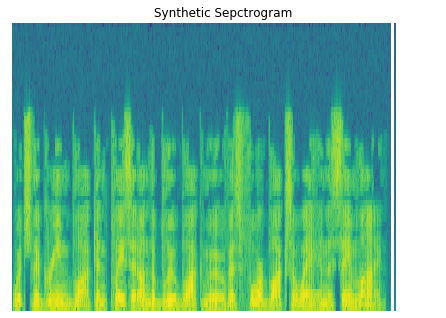

In [25]:
FS, data = wavfile.read('output.wav')  # read wav file
fig,ax = plt.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.specgram(data, Fs=FS, NFFT=128, noverlap=0)  # plot
ax.axis('tight')
ax.axis('off')
plt.title("Synthetic Sepctrogram")
plt.savefig('spectrogram_synthetic sample')
plt.show()

In [26]:
# extract_spectrogram_from_audio('./Data/generated_wav/*.wav', './Data/generated_spectos/')

In [27]:
# extract_spectrogram_from_audio('./Data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/**/*.wav', './Data/real_spectos/')

<h2 style="color:#3a7aad">Loading image Arrays</h2>

In [28]:
generated_images_dataset, generated_classes = load_images_as_dataframe('./Data/generated_spectos/*.jpg', 1)

100% (44084 of 44084) |##################| Elapsed Time: 0:01:23 Time:  0:01:23


In [29]:
real_images_dataset, real_classes = load_images_as_dataframe('./Data/real_spectos/*.jpg', 0)

100% (44242 of 44242) |##################| Elapsed Time: 0:01:32 Time:  0:01:32


In [30]:
print('Number of synthetic voices = ' + str(len(generated_images_dataset)))
print('Number of real voices = ' + str(len(real_images_dataset)))

Number of synthetic voices = 44084
Number of real voices = 44242


In [31]:
images_dataset = np.concatenate((generated_images_dataset[0:3000], real_images_dataset[0:3000]), axis=0)
classes_dataset = np.concatenate((generated_classes[0:3000], real_classes[0:3000]), axis=0)
print('Total Number of Voices = ' + str(len(images_dataset)))

Total Number of Voices = 6000


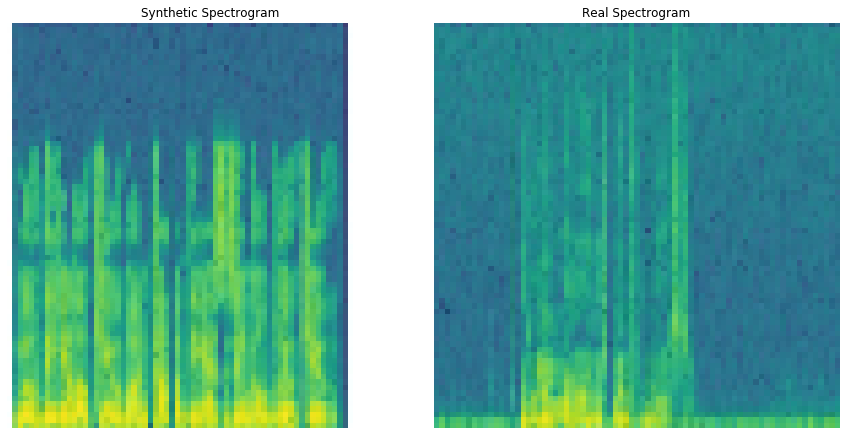

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)

ax[0].imshow(images_dataset[0])
ax[0].set_title('Synthetic Spectrogram')
ax[0].axis('off')

ax[1].imshow(real_images_dataset[0])
ax[1].set_title('Real Spectrogram')
ax[1].axis('off')

plt.tight_layout()
plt.show()

<h2 style="color:#3a7aad">RGB Distribution</h2>

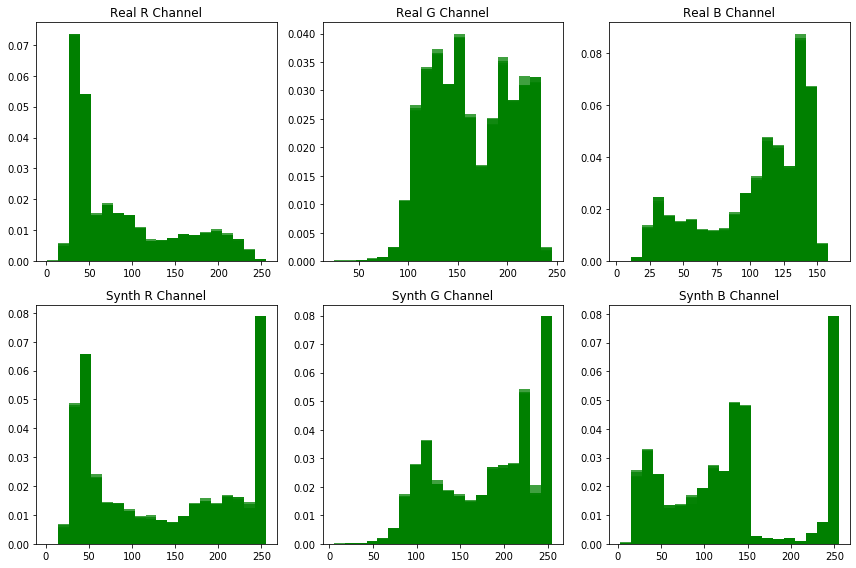

In [33]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

real_images_subset = real_images_dataset[0:3000]
gen_images_subset = generated_images_dataset[0:3000]

ax[0, 0].hist(real_images_subset[:,:,:,0].reshape(-1, 75*75), 
            20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[0, 0].set_title('Real R Channel')
 
ax[0, 1].hist(real_images_subset[:,:,:,1].reshape(-1, 75*75), 
            20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[0, 1].set_title('Real G Channel')
 
ax[0, 2].hist(real_images_subset[:,:,:,2].reshape(-1, 75*75), 
            20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[0, 2].set_title('Real B Channel')


ax[1, 0].hist(gen_images_subset[:,:,:,0].reshape(-1, 75*75), 
              20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[1, 0].set_title('Synth R Channel')

ax[1, 1].hist(gen_images_subset[:,:,:,1].reshape(-1, 75*75), 
              20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[1, 1].set_title('Synth G Channel')

ax[1, 2].hist(gen_images_subset[:,:,:,2].reshape(-1, 75*75), 
              20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax[1, 2].set_title('Synth B Channel')

fig.tight_layout()
plt.show()

<h2 style="color:#3a7aad">Feature Extraction with MobileNetV2</h2>

In [34]:
model = tf.keras.applications.MobileNetV2(include_top=False, 
                                          weights='imagenet', 
                                          input_shape=(75, 75, 3))

image_features = []
with progressbar.ProgressBar(max_value=len(images_dataset)) as bar:
    for index, image in enumerate(images_dataset):
        image = image.reshape(1, 75, 75, 3)
        image_features.append(model.predict(image))
        bar.update(index)

# pred_images = predictions.reshape(images_dataset.shape[0], -1)

100% (6000 of 6000) |####################| Elapsed Time: 0:02:43 Time:  0:02:43


In [35]:
with open('image_features.pickle', 'wb') as f:
    np.save(f, np.array(image_features))

In [36]:
with open('image_features.pickle', 'rb') as f:
    image_features = np.load(f)
image_features = image_features.reshape(len(image_features), -1)

<h2 style="color:#3a7aad">t-SNE: t-Distributed Stochastic Neighbor Embedding¶</h2>

In [37]:
from sklearn.manifold import TSNE

image_features_embedded = TSNE(n_components = 2, random_state = 0).fit_transform(image_features)

In [38]:
image_features_embedded[0:10]

array([[-29.755552  ,  40.486282  ],
       [ 17.8768    ,  63.58964   ],
       [ -0.07266986,  -2.1049278 ],
       [-24.088335  ,  69.69938   ],
       [-25.29861   ,  63.67776   ],
       [ -1.6752195 ,  46.783432  ],
       [-13.62255   ,  31.617346  ],
       [ 20.23105   ,  57.87435   ],
       [  5.5645967 ,   3.762322  ],
       [ 20.38691   ,  71.341095  ]], dtype=float32)

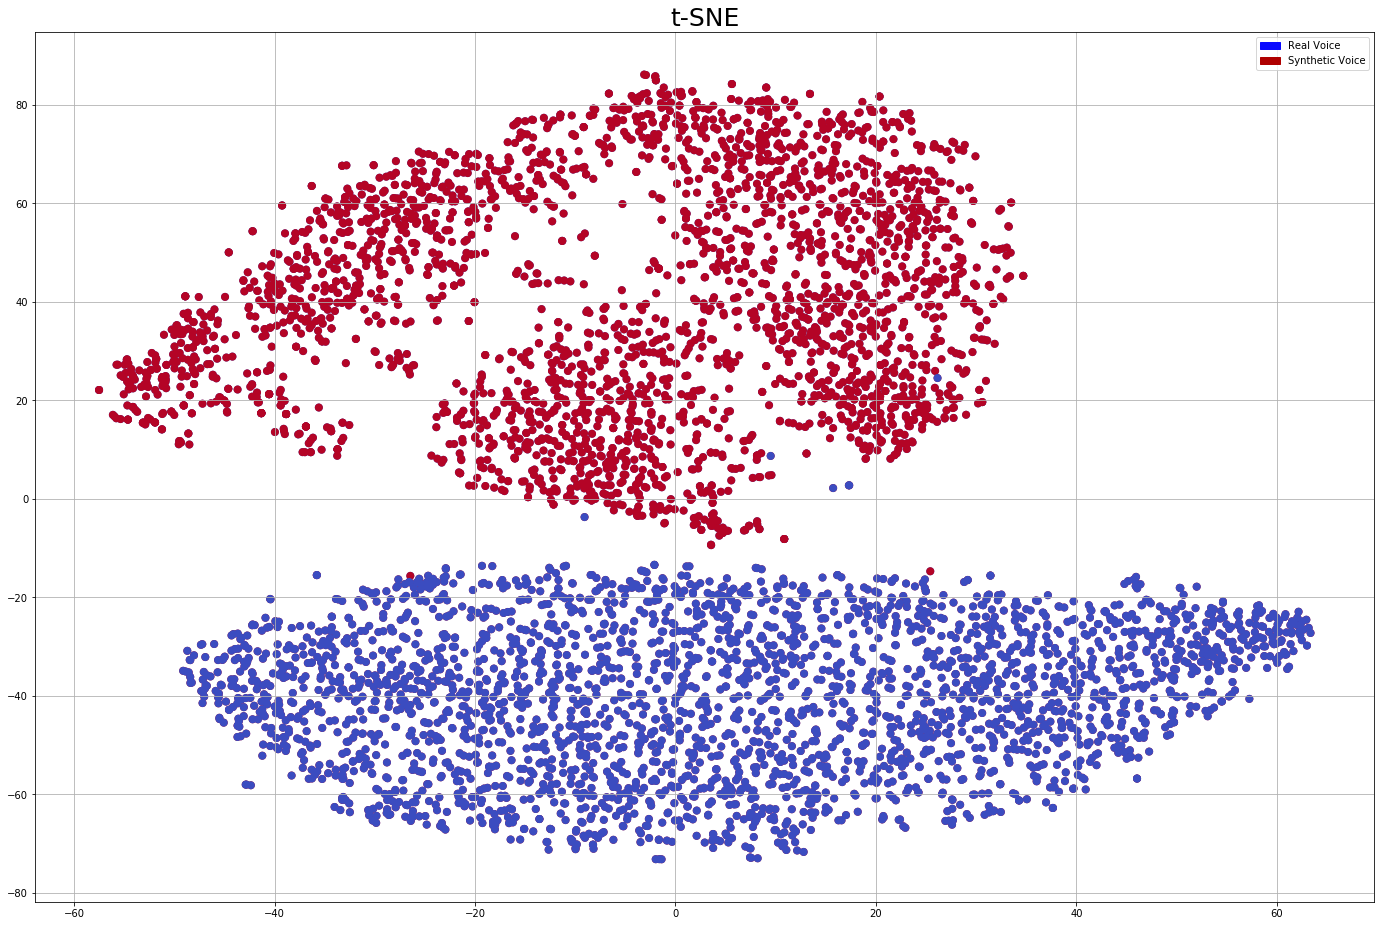

In [39]:
f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Real Voice')
red_patch = mpatches.Patch(color='#AF0000', label='Synthetic Voice')

ax.scatter(image_features_embedded[:,0], image_features_embedded[:,1], 
           c=(classes_dataset == 0), cmap='coolwarm', label='Real', linewidths=2)

ax.scatter(image_features_embedded[:,0], image_features_embedded[:,1], 
           c=(classes_dataset == 1), cmap='coolwarm', label='Synthetic', linewidths=2)

ax.set_title('t-SNE', fontsize=25)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

<h2 style="color:#3a7aad">Train-Test Split¶</h2>

In [40]:
X = images_dataset
y = adjust_classes(classes_dataset)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Synthetic voices training samples = 4500
Real voices training samples = 4500
Synthetic test samples = 1500
Real test samples = 1500


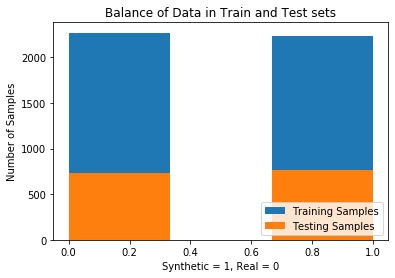

In [41]:
print(f"Synthetic voices training samples = {len(np.where(y_train == 1)[0])}")
print(f"Real voices training samples = {len(np.where(y_train == 0)[0])}")
print(f"Synthetic test samples = {len(np.where(y_test == 1)[0])}")
print(f"Real test samples = {len(np.where(y_test == 0)[0])}")

plt.hist(x = y_train[:,0], bins=3)
plt.hist(x = y_test[:,0], bins=3)
plt.legend(["Training Samples", "Testing Samples"], loc ="lower right") 
plt.xlabel("Synthetic = 1, Real = 0")
plt.ylabel("Number of Samples")
plt.title("Balance of Data in Train and Test sets")
plt.show()

<h2 style="color:#3a7aad">Inception v3 Model¶</h2>

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten

inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(75, 75, 3),
    pooling=None, classes=1000, classifier_activation=None
)
for layer in inception_model.layers:
    layer.trainable = False
x = Flatten()(inception_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(75, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='sigmoid')(x)

inception_model = tf.keras.Model(inception_model.input, x)
# inception_model.summary()

In [51]:
epochs = 5
batch_size = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, name='adam')
loss_function = tf.keras.losses.binary_crossentropy

inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = inception_model.fit(x=X_train,
                   y=y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=0.2)

Epoch 1/5
720/720 [==============================] - 15s 21ms/step - loss: 55.9181 - accuracy: 0.9822 - val_loss: 0.6623 - val_accuracy: 0.9956
Epoch 2/5
720/720 [==============================] - 14s 20ms/step - loss: 3.6901 - accuracy: 0.9928 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
720/720 [==============================] - 14s 19ms/step - loss: 70.7173 - accuracy: 0.9875 - val_loss: 0.4493 - val_accuracy: 0.9978
Epoch 4/5
720/720 [==============================] - 14s 19ms/step - loss: 61.0040 - accuracy: 0.9947 - val_loss: 3.7914 - val_accuracy: 0.9978
Epoch 5/5
720/720 [==============================] - 14s 19ms/step - loss: 44.8270 - accuracy: 0.9908 - val_loss: 34.6280 - val_accuracy: 0.9956


In [52]:
from sklearn.metrics import accuracy_score

y_pred_proba = inception_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=-1)
accuracy_score(y_test[:,1], y_pred)

0.9993333333333333

In [53]:
inception_model.save('model.h5')

<h3 style="color:#3a7aad">Training History Plots</h3>

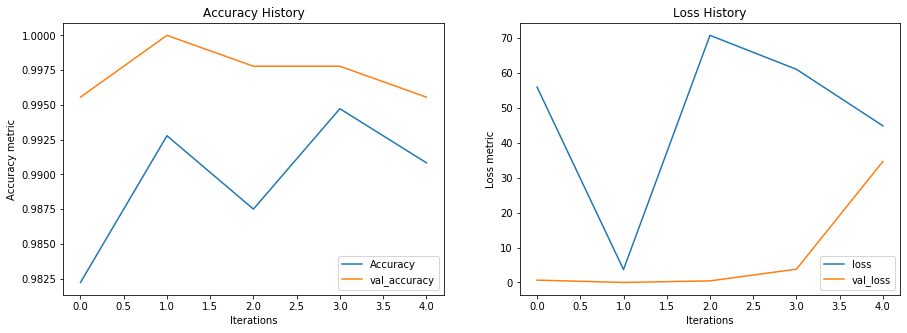

In [54]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy History')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Accuracy metric')
ax[0].legend(["Accuracy", "val_accuracy"], loc ="lower right") 

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss History')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Loss metric')
ax[1].legend(["loss", "val_loss"], loc ="lower right") 

plt.show()

<h3 style="color:#3a7aad">Further testing model on more data</h3>

In [55]:
f_images_dataset = np.concatenate((generated_images_dataset[3000:-1], real_images_dataset[3000:-1]), axis=0)
f_classes_dataset = np.concatenate((generated_classes[3000:-1], real_classes[3000:-1]), axis=0)

In [56]:
y_pred_proba = inception_model.predict(f_images_dataset)
y_pred = np.argmax(y_pred_proba, axis=-1)
1 - accuracy_score(f_classes_dataset, y_pred)

0.9988338759049609